# Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mpl
import datetime as dt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
warnings.filterwarnings('ignore')

# Obtención del conjunto de datos

Para la realización de este proyecto se emplea un conjunto de datos históticos relacionado a las ventas registradas por una e-commerce.  

In [4]:
df0 = pd.read_csv('ventas-por-factura.csv')

In [5]:
df = df0.copy()

In [6]:
df.shape

(25953, 6)

In [7]:
df.head()

,N° de factura,Fecha de factura,ID Cliente,País,Cantidad,Monto
0,548370,3/30/2021 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.0,United Kingdom,163,"209,73"
2,C570727,10/12/2021 11:32:00,12471.0,Germany,-1,"-1,45"
3,549106,4/6/2021 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.0,United Kingdom,357,"344,83"


Este conjunto de datos posee un total de seis columnas, siendo estas: Número de factura, Fecha de factura, ID Cliente, País, Cantidad y Monto. Además, está compuesto, inicialmente, por una cantidad de 25953 registros.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   N° de factura     25953 non-null  object 
 1   Fecha de factura  25953 non-null  object 
 2   ID Cliente        22229 non-null  float64
 3   País              25953 non-null  object 
 4   Cantidad          25953 non-null  int64  
 5   Monto             25953 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


# Depuración y limpieza de datos

A continuación se procede a realizar la limpieza y respectiva conversión de los tipos de datos en este conjunto.

In [9]:
df["Monto"] = df["Monto"].str.replace(",",".").astype(float)

In [10]:
df["Fecha de factura"] = pd.to_datetime(df["Fecha de factura"]).dt.date
df["Fecha de factura"] = pd.to_datetime(df["Fecha de factura"])

Las columnas, en donde se ha aplicado la conversión de datos, corresponden a "Fecha de factura", que pasó de ser de tipo cadena a datetime (permitiendo manipular la fecha y la hora del registro), y Monto, que pasó a ser de tipo flotante.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   N° de factura     25953 non-null  object        
 1   Fecha de factura  25953 non-null  datetime64[ns]
 2   ID Cliente        22229 non-null  float64       
 3   País              25953 non-null  object        
 4   Cantidad          25953 non-null  int64         
 5   Monto             25953 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB


Existen valores negativos en cuanto a la columna "Cantidad", no obstante, estos valores indican las devoluciones realizadas. Ya que este es un análisis sobre las ventas, se procederán a eliminar los registros que contengan devoluciones.

In [12]:
df = df[~df["N° de factura"].str.contains("C")]

Luego, se procede a comprobar si existen datos nulos.

In [13]:
df.isnull().sum()

N° de factura          0
Fecha de factura       0
ID Cliente          3542
País                   0
Cantidad               0
Monto                  0
dtype: int64

Existen 3542 registros que poseen datos nulos en la columna correspondiente al ID del cliente. Al ser la cantidad total de registros, sin contar esta columna, de 25953, la eliminación de la misma no contribuye a un efecto circunstancial en el posterior anális, por ende, se procede a eliminar.

In [14]:
df = df.dropna()

In [15]:
df.shape

(18570, 6)

A continuación, el "ID Cliente" se convierte a tipo entero.

In [16]:
df['ID Cliente'] = df['ID Cliente'].astype(int)

In [17]:
df['N° de factura'].nunique()

18536

Realizando el conteo de los valores únicos de la columna "Números de factura", se deja en evidencia que existen valores duplicados, por ende, ya que las facturas deben ser únicas, se procederá a eliminar los valores duplicados.

In [18]:
df = df.drop_duplicates(['N° de factura'], keep='first')

In [19]:
df.shape

(18536, 6)

Luego de los procesos de casting y la eliminación de valores nulos y duplicados (preprocesamiento de datos), la cantidad total de registros es de 18536. A partir de esta cantidad, se procederá a realizar la respectiva exploración de los datos.

# Exploración de datos

## Análisis de las métricas de ventas

Para realizar la respectiva exploración de los datos, se analizarán algunas métricas de ventas contenidos en este conjunto de datos.

### Análisis de número de facturas por país

La primera métrica a evaluar corresponde al número de facturas por país. En este caso, se analizan los 4 países con los porcentajes de facturas más altos.

In [20]:
fpP = df.groupby(by=['País']).aggregate({'N° de factura':'count'})

In [21]:
fpP['Porcentaje'] = (fpP['N° de factura']/fpP['N° de factura'].sum()*100)

In [22]:
fpP.sort_values('Porcentaje', ascending = False).head(4)

,N° de factura,Porcentaje
País,,
United Kingdom,16649,89.819810
Germany,457,2.465473
France,389,2.098619
EIRE,260,1.402676


El 89.82% de las facturas pertenecen a los clientes de Reino Unido (UK), siendo este el país en donde surgió el negocio. Además, existen tres países cuyo porcentaje supera al menos el 1%, siendo estos: Alemania (Germany), Francia (France) e Irlanda (EIRE).

### Análisis del monto total por país

In [23]:
mpP  = df.groupby(by=['País']).aggregate(Monto = ('Monto','sum'),
                                         Monto_promedio = ('Monto', 'mean'),
                                         Monto_mínimo = ('Monto', 'min'),
                                         Monto_máximo = ('Monto', 'max'))

In [24]:
mpP['Porcentaje'] = (mpP['Monto']/mpP['Monto'].sum()*100)

In [25]:
mpP.sort_values('Monto', ascending = False).head(4).round(2)

,Monto,Monto_promedio,Monto_mínimo,Monto_máximo,Porcentaje
País,,,,,
United Kingdom,7298806.28,438.39,0.00,168469.60,82.00
Netherlands,285446.34,3004.70,0.00,20277.92,3.21
EIRE,265341.00,1020.54,1.45,16774.72,2.98
Germany,228867.14,500.80,3.00,9341.26,2.57


Comparando esta tabla con la anterior, se evidencia que, para el caso del porcentaje total de facturas, Reino Unido representaba un valor que superaba el 89%, no obstante, al analizar las ventas realizadas, esta nación insular solo representa el 82% de las ventas totales. La columna que explica esto es "Monto promedio".

En base a lo anterior, aunque hayan existan países que tengan un alto porcentaje correspondiente a las facturas, los promedios por transacción variarán y sus porcentajes más altos girarán en torno a otros países.

In [26]:
mpP.sort_values('Monto_promedio', ascending = False).head(3).round(2)

,Monto,Monto_promedio,Monto_mínimo,Monto_máximo,Porcentaje
País,,,,,
Singapore,21279.29,3039.9,999.26,6068.06,0.24
Netherlands,285446.34,3004.7,0.00,20277.92,3.21
Australia,138521.31,2430.2,61.20,22775.93,1.56


La tabla anterior muestra a las tres naciones con mayor porcentaje por transacción, siendo estas: Singapur, con un 3039.9; Países Bajos, con un 3004.7; y, Australia, con un 2430.2

A pesar de lo analizado anteriormente, es importante mencionar que existen países cuyos montos mínimos son de 0.

### Facturas generadas por mes

In [27]:
df['Año-Mes'] = df['Fecha de factura'].apply(lambda x:x.strftime('%Y-%m'))

In [28]:
df.head()

,N° de factura,Fecha de factura,ID Cliente,País,Cantidad,Monto,Año-Mes
0,548370,2021-03-30,15528,United Kingdom,123,229.33,2021-03
1,575767,2021-11-11,17348,United Kingdom,163,209.73,2021-11
3,549106,2021-04-06,17045,United Kingdom,1,39.95,2021-04
4,573112,2021-10-27,16416,United Kingdom,357,344.83,2021-10
5,576630,2021-11-16,13816,Germany,91,199.98,2021-11


In [29]:
fpM = df.groupby(by=['Año-Mes']).aggregate({'N° de factura':'count'})

In [30]:
fpM = fpM.reset_index()

In [31]:
fpM.head()

,Año-Mes,N° de factura
0,2020-12,1400
1,2021-01,987
2,2021-02,998
3,2021-03,1321
4,2021-04,1149


In [32]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

In [33]:
fpMAM = list(fpM['Año-Mes'])

In [34]:
# df.groupby(by=['Año-Mes']).aggregate({'N° de factura':'count'}).plot(style='.-', ms = 10)
# plt.xticks(ticks = np.arange(len(fpM)), labels=fpMAM, rotation = 45)
# plt.title('Número de facturas por mes')
# plt.xlabel('Mes')
# plt.ylabel('Facturas')
# plt.legend().remove()
# plt.show()

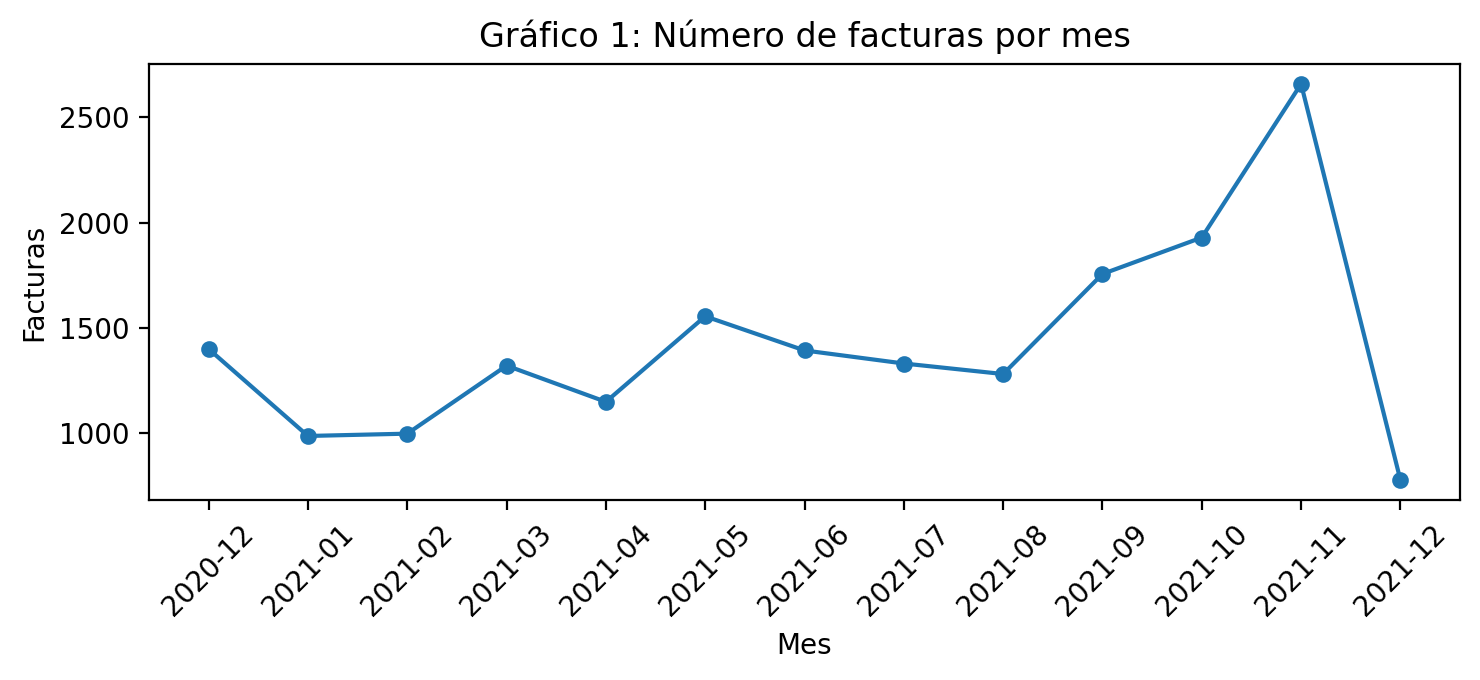

In [35]:
plt.rcParams['figure.dpi'] = 200
fpM.plot(x = 'Año-Mes', y = 'N° de factura', style='.-', ms = 10);
plt.xticks(ticks = np.arange(len(fpM)), labels=fpMAM, rotation = 45)
plt.title('Gráfico 1: Número de facturas por mes')
plt.xlabel('Mes')
plt.ylabel('Facturas')
plt.legend().remove()
plt.show()

El gráfico anterior evidencia una subida en las ventas para el mes de noviembre. Esto puede corresponder a las posteriores celebridades del mes de Diciembre, no obstante, en este último mes, se aprecia cómo las ventas decrecen de forma acelerada en comparación con los demás meses, en incluso, posee un valor menor que las ventas de Diciembre del año anterior.

In [36]:
dfD = df[df['Año-Mes'] == '2021-12']

In [37]:
dfD2 = dfD.groupby(by=['Fecha de factura']).aggregate({'N° de factura':'count'})

In [38]:
dfD2 = dfD2.reset_index()

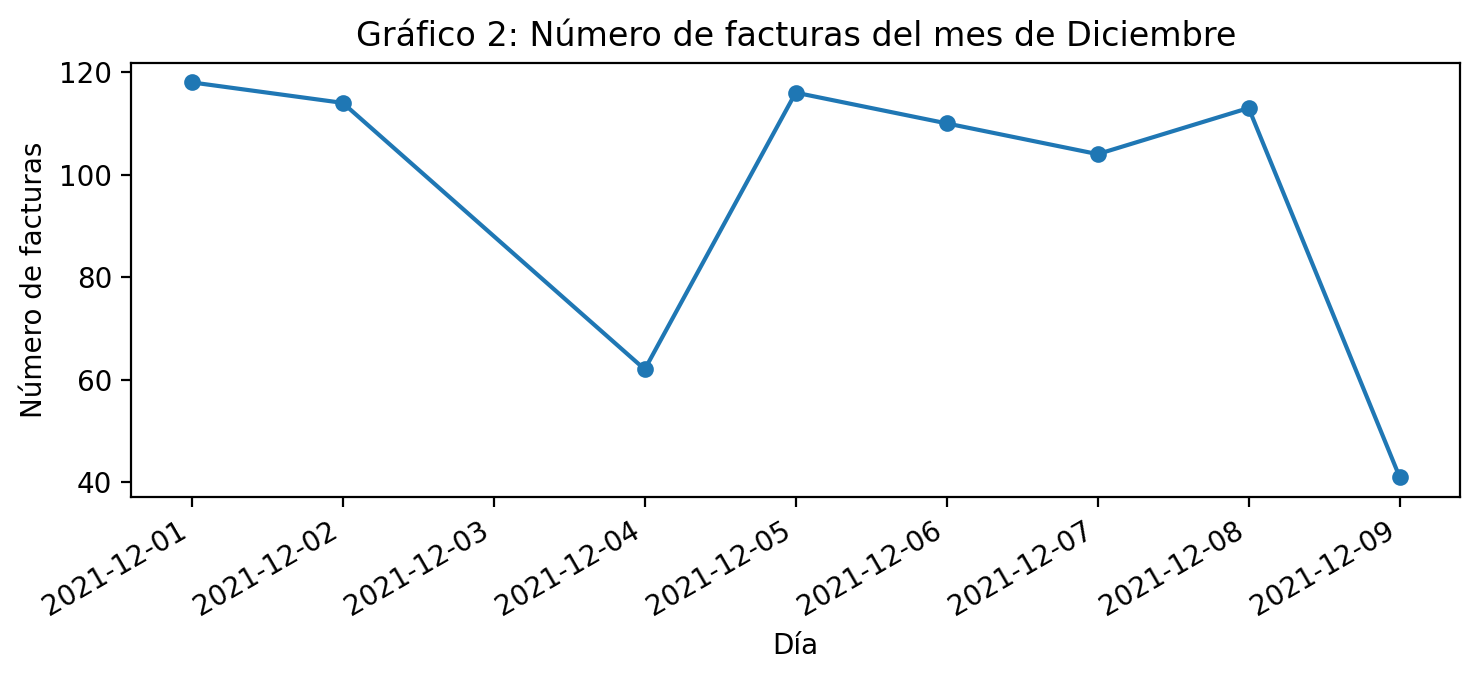

In [39]:
dfD2.plot(x = 'Fecha de factura', y = 'N° de factura', style='.-', ms = 10)
plt.xlabel('Día')
plt.ylabel('Número de facturas')
plt.title('Gráfico 2: Número de facturas del mes de Diciembre')
plt.legend().remove()

En cuanto a las ventas realizadas en Diciembre del año 2021, se puede observar los días 4 y 9 fueron los días que menos ventas hubo.

### Número de facturas en Reino Unido (UK) vs países extranjeros por mes

In [40]:
df['Ubicación'] = np.where(df['País']=='United Kingdom', 'United Kingdom', 'Other')

In [41]:
u = df.groupby(['Año-Mes', 'Ubicación']).aggregate({'N° de factura':'count'}).reset_index()

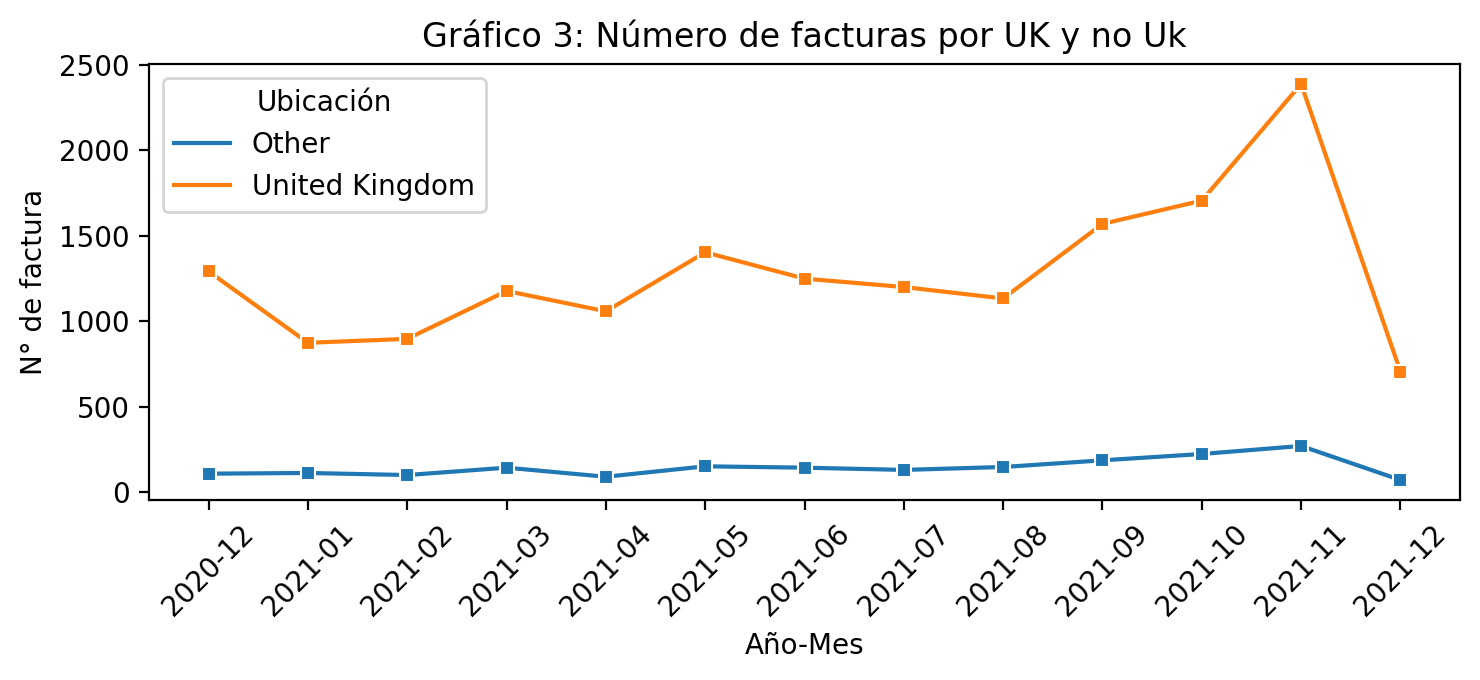

In [42]:
sns.lineplot(data=u, x="Año-Mes", y="N° de factura", hue = 'Ubicación', marker="s", ms=5)
plt.xticks(ticks = np.arange(len(fpM)), labels=fpMAM, rotation = 45)
plt.title('Gráfico 3: Número de facturas por UK y no Uk')
plt.show()

La gráfica anterior evidencia un notable crecimiento de las ventas para ambos segmentos (dentro y fuera de UK). Por ende, es considerable que el impacto que tuvieron los servicios/productos ofrecidos por la organización, tuvieron un alcance positivo lo que posibilitó no solo aumentos de ventas dentro de UK, sino también, fuera. A pesar de esto, se excluye el mes de Diciembre por considerarse un valor atípico.

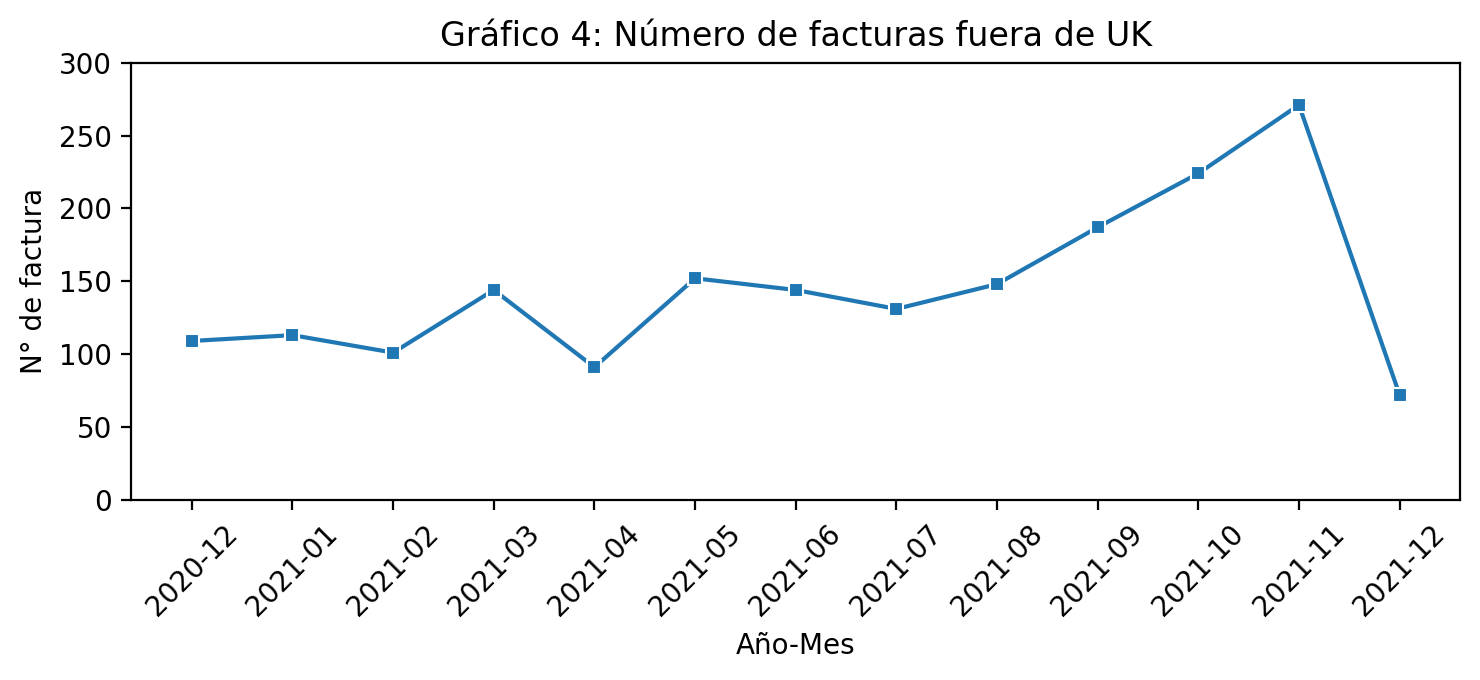

In [43]:
sns.lineplot(data=u[u['Ubicación'] == 'Other'], x="Año-Mes", y="N° de factura", hue = 'Ubicación', marker="s", ms=5)
plt.xticks(ticks = np.arange(len(fpM)), labels=fpMAM, rotation = 45)
plt.title('Gráfico 4: Número de facturas fuera de UK')
plt.ylim(0, 300)
plt.legend().remove()
plt.show()

Aquí, se puede apreciar de mejor manera la caída de las ventas para el mes atípico en lo que respecta a la cantidad de facturas fuera de UK.

### Cantidad de clientes nuevos por mes

In [44]:
cpM = df.groupby(['Año-Mes']).aggregate({'ID Cliente':'nunique'}).reset_index()

In [45]:
cpM.rename({'ID Cliente': 'Clientes Únicos'}, axis=1, inplace=True)

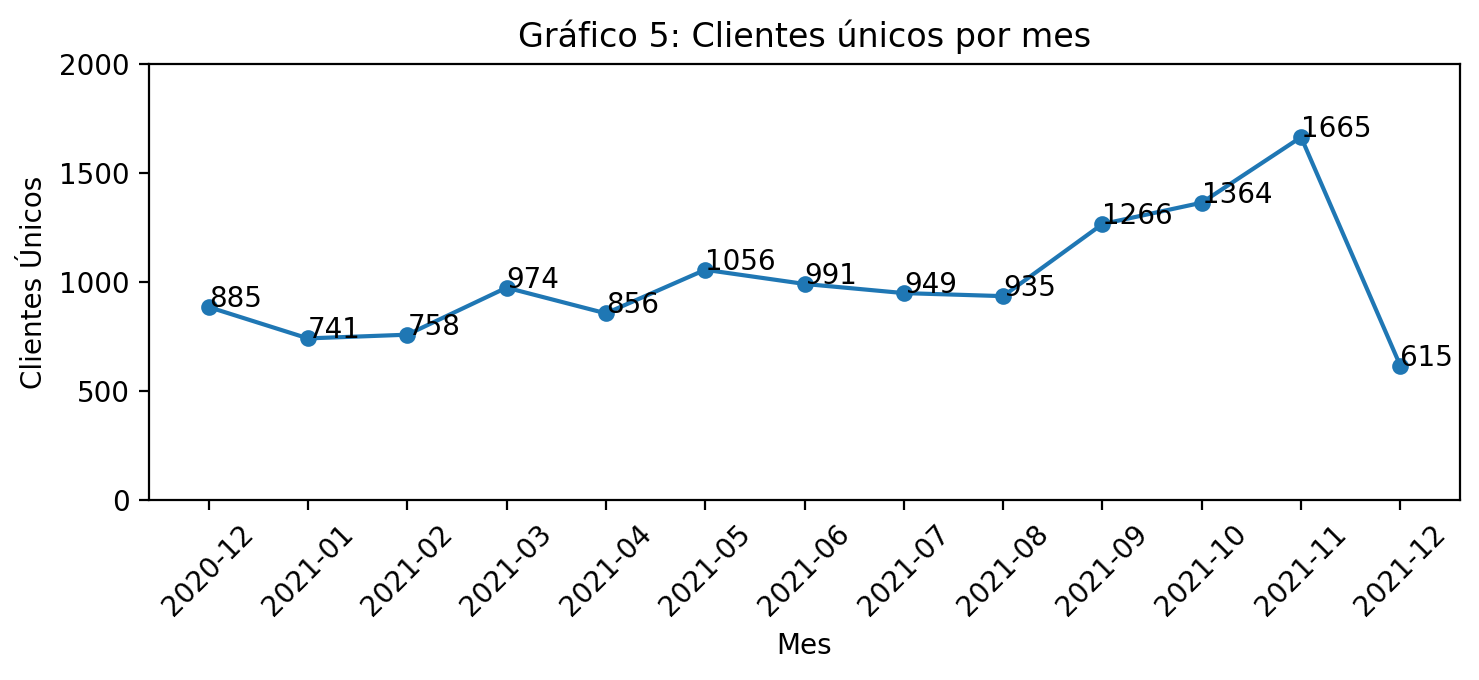

In [46]:
#plt.rcParams['figure.dpi'] = 350
cpM.plot(x = 'Año-Mes', y = 'Clientes Únicos', style='.-', ms = 10)
plt.xticks(ticks = np.arange(len(fpM)), labels=fpMAM, rotation = 45)
for x,y in zip(cpM['Año-Mes'].index, cpM['Clientes Únicos'] ):
    label = '{}'.format(y)
    plt.annotate(label, # this is the value which we want to label (text)
                 (x,y))
plt.ylim(0, 2000)
plt.title('Gráfico 5: Clientes únicos por mes')
plt.xlabel('Mes')
plt.ylabel('Clientes Únicos')
plt.legend().remove()
plt.show()

En la gráfica anterior, se puede apreciar que la cantidad de clientes nuevos fue de 1665 durante el mes de Noviembre, mientras que, para Diciembre, esta cifra disminuyó hasta unos 615.

# Análisis de cohortes

A continuación, se procede a realizar el análisis de cohortes por medio de la tasa de retención de clientes.

In [47]:
dfCohorte = df[df.columns[:-2]]

In [48]:
def obtenerMes(x):
    return dt.datetime(x.year,x.month,1)

In [49]:
dfCohorte['Mes de factura'] = dfCohorte['Fecha de factura'].apply(obtenerMes)

In [50]:
agrupamiento = dfCohorte.groupby('ID Cliente')['Mes de factura']

In [51]:
dfCohorte['Mes de cohorte'] = agrupamiento.transform('min')

El código anterior permite establecer un punto de partida de este análisis, seleccionando la primera fecha de factura de cada cliente.

In [52]:
dfCohorte.tail()

,N° de factura,Fecha de factura,ID Cliente,País,Cantidad,Monto,Mes de factura,Mes de cohorte
25945,579252,2021-11-28,17450,United Kingdom,432,1034.40,2021-11-01,2020-12-01
25946,574908,2021-11-07,16009,United Kingdom,28,82.76,2021-11-01,2021-07-01
25949,553060,2021-05-13,15826,United Kingdom,488,720.00,2021-05-01,2021-05-01
25950,577049,2021-11-17,17397,United Kingdom,104,298.78,2021-11-01,2021-11-01
25951,550122,2021-04-14,12931,United Kingdom,1176,1488.00,2021-04-01,2020-12-01


De esta manera, se establecen dos columnas nuevas "Mes de factura" y "Mes de cohorte". Esto posibilitará obtener los valores correspondientes a la tasa de retención de clientes correspondientes al periodo de tiempo de este conjunto de datos (desde Diciembre 2020 hasta Diciembre 2021).

In [53]:
def obtenerFecha (dframe,columna):
    anio = dframe[columna].dt.year
    mes = dframe[columna].dt.month
    dia = dframe[columna].dt.day
    return anio, mes, dia 

In [54]:
facturaAnio, facturaMes, _ = obtenerFecha(dfCohorte,'Mes de factura')
cohorteAnio, cohorteMes, _ = obtenerFecha(dfCohorte,'Mes de cohorte')

In [55]:
anioDif = facturaAnio - cohorteAnio 
mesDif = facturaMes - cohorteMes 

In [56]:
dfCohorte['Índice de cohorte'] = anioDif * 12 + mesDif + 1 

In [57]:
agrupamiento2 = dfCohorte.groupby(['Mes de cohorte', 'Índice de cohorte'])

In [58]:
cohorteData = agrupamiento2['ID Cliente'].apply(pd.Series.nunique)

In [59]:
cohorteData = cohorteData.reset_index()

In [60]:
cohorteConteo = cohorteData.pivot(index='Mes de cohorte',columns='Índice de cohorte',values='ID Cliente')

In [61]:
cohorteConteo

Índice de cohorte,1,2,3,4,5,6,7,8,9,10,11,12,13
Mes de cohorte,,,,,,,,,,,,,
2020-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2021-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2021-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2021-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2021-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2021-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2021-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ya obtenidos los valores del conteo de cada cohorte dentro del conjunto de datos, el siguiente paso es obtener la tasa de retención dentro de cada una.

In [62]:
cohorteTamanio = cohorteConteo.iloc[:,0]
retencion = cohorteConteo.divide(cohorteTamanio,axis=0)  
retencion.round(3) * 100 

Índice de cohorte,1,2,3,4,5,6,7,8,9,10,11,12,13
Mes de cohorte,,,,,,,,,,,,,
2020-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2021-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2021-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2021-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2021-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2021-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2021-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se puede apreciar la tasa de retención de cliente para cada cohorte, no obstante, se procederá a crear un mapa de calor que represente esta información de una mejor manera.

In [63]:
listaMeses = ["Diciembre 2020", "Enero 2021", "Febrero 2021", "Marzo 2021", "Abril 2021",
              "Mayo 2021", "Junio 2021", "Julio 2021", "Agosto 2021", "Septiembre 2021", 
              "Octubre 2021", "Noviembre 2021", "Diciembre 2021"]

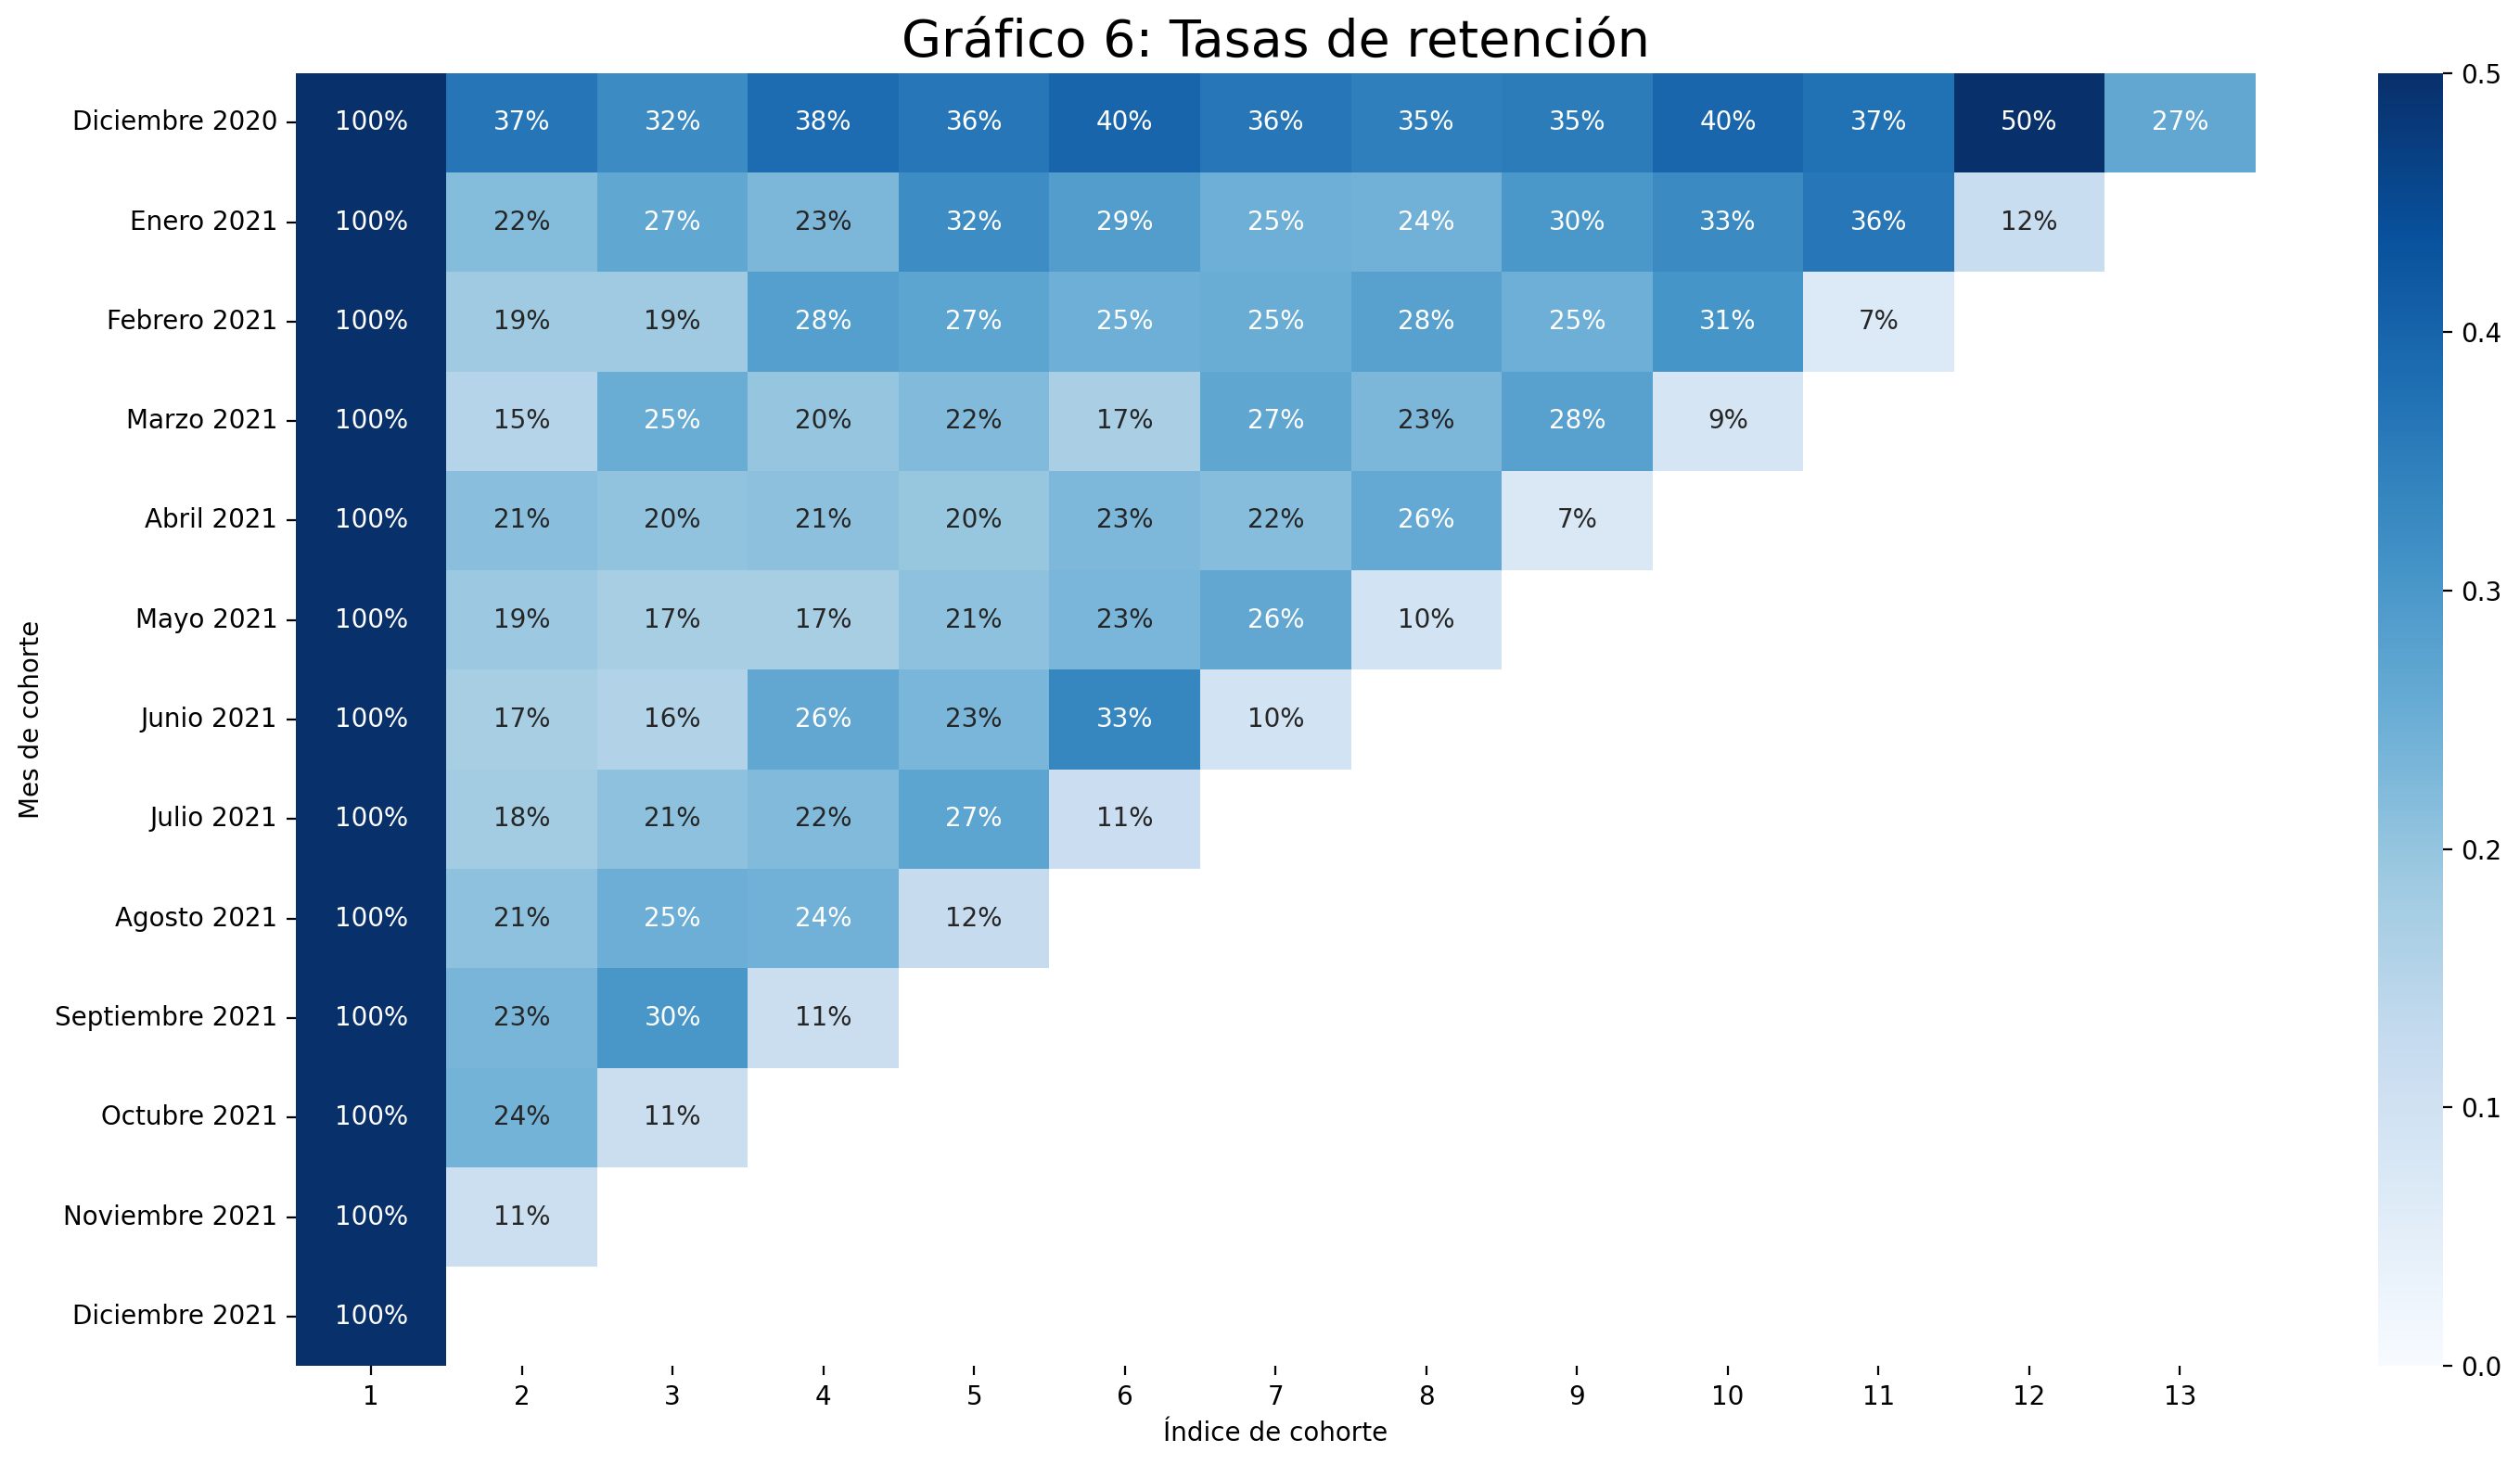

In [64]:
plt.figure(figsize=(15, 8))
plt.title('Gráfico 6: Tasas de retención', fontsize = 20)
sns.heatmap(data=retencion, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, yticklabels=listaMeses, cmap = "Blues")
plt.show()

En el gráfico anterior se puede apreciar el análisis de cohortes mediante un mapa de calor, en donde, el valor de la intensidad varía de 0.0 a 0.5, el valor máximo. Son 13 las cohortes analizadas, con una ventana de tiempo mensual, de las cuales, se obtiene la siguiente información:

<ul>
    <li>Para la cohorte "Diciembre 2020", se produce una retención del 50% al llegar al índice de cohorte 12, pero, para el siguiente índice, este tasa disminuye acercándose a la mitad (27%).</li>
    <li>La cohorte "Enero 2021" muestra su mayor valor en el índice 11, con una tasa del 36%.</li>
    <li>Para "Febrero 2021", la mayor tasa corresponde a un 31%, en el índice 10.</li>
    <li>La cohorte "Marzo 2021" posee el segundo valor más bajo del índice 2, siendo esta una tasa del 15%. El valor más bajo lo mantiene la corte de "Noviembre 2021" con una tasa del 11%.</li>
    <li>La tasa de retención más baja es de 7%, la misma que se presenta en el índice 11 de la cohorte "Febrero 2021" y el índice 9 para "Abril 2021".</li>
</ul>

# Segmentación de clientes

Una vez realizado el análisis de cohortes empleando la tasa de retención de clientes, se procede a segmentar los clientes mediante el análisis RFM (Recencia, Frecuencia y Valor Monetario). Para esto, se excluye del conjunto de datos los registros cuyo monto sea igual a 0.

In [65]:
df[df["Monto"] == 0.0]

,N° de factura,Fecha de factura,ID Cliente,País,Cantidad,Monto,Año-Mes,Ubicación
3668,564651,2021-08-26,14646,Netherlands,576,0.0,2021-08,Other
4752,543599,2021-02-10,17560,United Kingdom,16,0.0,2021-02,United Kingdom
12491,578841,2021-11-25,13256,United Kingdom,12540,0.0,2021-11,United Kingdom
15195,568384,2021-09-27,12748,United Kingdom,1,0.0,2021-09,United Kingdom


In [66]:
df = df[df["Monto"] > 0.0]

Para realizar el análisis RFM, se empleará la fecha mayoe contenida dentro del conjunto de datos.

In [67]:
df["Fecha de factura"].max()

Timestamp('2021-12-09 00:00:00')

Una vez obtenida, se la instanciará mediante una variable.

In [68]:
fechaMax = dt.datetime(2021,12, 10)

Una vez realizado esto, se procederá a agrupar el conjunto de datos mediante la columna "ID Cliente", añadiendo cuatro columnas más (Cantidad, Monto, Número de factura y Fecha de factura). Estas columnas representarán a la recencia, frecuencia y valor monetario del posterior análisis.

In [69]:
dfRFM = df.groupby("ID Cliente").agg({"Cantidad": lambda x : x.sum(),
                               "Monto" : lambda x : x.sum(),
                               "N° de factura": "count",
                               "Fecha de factura" : lambda x: (fechaMax - x.max()).days})

In [70]:
dfRFM.head()

,Cantidad,Monto,N° de factura,Fecha de factura
ID Cliente,,,,
12346,74215,77183.60,1,326
12347,2458,4310.00,7,3
12348,2341,1797.24,4,76
12349,631,1757.55,1,19
12350,197,334.40,1,311


A continuación, se establecerá el conjunto de datos a emplear para realizar el análisis RFM.

In [71]:
rfm = dfRFM.copy()

In [72]:
rfm.columns = ["Cantidad","Valor monetario","Frecuencia","Recencia"]

In [73]:
rfm = rfm[rfm["Frecuencia"] > 1 ] 

In [74]:
rfm.head()

,Cantidad,Valor monetario,Frecuencia,Recencia
ID Cliente,,,,
12347,2458,4310.00,7,3
12348,2341,1797.24,4,76
12352,536,2506.04,8,37
12356,1591,2811.43,3,23
12358,248,1168.06,2,2


Así, el conjunto de datos estará empleado por "Cantidad", "Valor monetario", "Frecuencia" y "Recencia".

In [75]:
rfm["Puntuación de recencia"]= pd.qcut(rfm["Recencia"], 5, labels = [5, 4, 3, 2, 1])

In [76]:
rfm["Puntuación de frecuencia"]= pd.qcut(rfm["Frecuencia"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

In [77]:
rfm["Puntuación de valor monetario"]= pd.qcut(rfm["Valor monetario"], 5, labels = [1, 2, 3, 4, 5])

In [78]:
rfm["Puntuación RFM"] = (rfm['Puntuación de recencia'].astype(str) + rfm['Puntuación de frecuencia'].astype(str) + rfm['Puntuación de valor monetario'].astype(str))

In [79]:
rfm.head()

,Cantidad,Valor monetario,Frecuencia,Recencia,Puntuación de recencia,Puntuación de frecuencia,Puntuación de valor monetario,Puntuación RFM
ID Cliente,,,,,,,,
12347,2458,4310.00,7,3,5,4,5,545
12348,2341,1797.24,4,76,2,3,4,234
12352,536,2506.04,8,37,3,5,4,354
12356,1591,2811.43,3,23,4,2,4,424
12358,248,1168.06,2,2,5,1,3,513


Para la creación de las puntuaciones RFM, se realizó una separación de los datos en cinco cuantiles iguales, es decir, 0-20 %, 20-40%, 40-60%, 60-80% y 80-100%. De esta manera, la puntuación RFM está formada por 3 dígitos, representando a la recencia, frecuencia y valor monetario, respectivamente.

In [80]:
segMap = {}

In [81]:
clientesPerdidos = ['111', '112', '121', '131', '141', '151'] 
clientesFrios = ['132', '322', '231', '241', '251', '233', '232', '223', '222', '132', '123', '122', '212', '211']
clientesDormidos = ['155', '154', '144', '214', '215', '115', '114', '113']
clientesEnRiesgo = ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124']
clientesAtencion = ['535', '534', '443', '434', '343', '334', '325', '324', '331', '321', '312', '221', '213']
clientesPrometedores = ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313']
clientesNuevos = ['512', '511', '422', '421', '412', '411', '311']
clientesPotenFieles = ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323']
clientesFieles = ['543', '444', '435', '355', '354', '345', '344', '335']
clientesEstrella = ['555', '554', '544', '545', '454', '455', '445']

Lo anterior corresponde a la creación de un diccionario de datos  grupos para realizar la segmentación de clientes mediante el análisis RFM. Estos corresponden a cuales corresponden a diez grupos, desde los "clientes perdidos" hasta los "clientes estrella".

In [82]:
for clientesPerdidos in clientesPerdidos:
    segMap[clientesPerdidos] = 'Clientes perdidos'

In [83]:
for clientesFrios in clientesFrios:
    segMap[clientesFrios] = 'Clientes fríos'

In [84]:
for clientesDormidos in clientesDormidos:
    segMap[clientesDormidos] = 'Clientes dormidos'

In [85]:
for clientesEnRiesgo in clientesEnRiesgo:
    segMap[clientesEnRiesgo] = 'Clientes en riesgo'

In [86]:
for clientesAtencion in clientesAtencion:
    segMap[clientesAtencion] = 'Clientes que requieren atención'

In [87]:
for clientesPrometedores in clientesPrometedores:
    segMap[clientesPrometedores] = 'Clientes prometedores'

In [88]:
for clientesNuevos in clientesNuevos:
    segMap[clientesNuevos] = 'Clientes nuevos'

In [89]:
for clientesPotenFieles in clientesPotenFieles:
    segMap[clientesPotenFieles] = 'Clientes potencialmente fieles'

In [90]:
for clientesFieles in clientesFieles:
    segMap[clientesFieles] = 'Clientes fieles'

In [91]:
for clientesEstrella in clientesEstrella:
    segMap[clientesEstrella] = 'Clientes estrella'

In [92]:
rfm['Segmento'] =  rfm["Puntuación RFM"].map(segMap)

In [93]:
rfm.head()

,Cantidad,Valor monetario,Frecuencia,Recencia,Puntuación de recencia,Puntuación de frecuencia,Puntuación de valor monetario,Puntuación RFM,Segmento
ID Cliente,,,,,,,,,
12347,2458,4310.00,7,3,5,4,5,545,Clientes estrella
12348,2341,1797.24,4,76,2,3,4,234,Clientes en riesgo
12352,536,2506.04,8,37,3,5,4,354,Clientes fieles
12356,1591,2811.43,3,23,4,2,4,424,Clientes prometedores
12358,248,1168.06,2,2,5,1,3,513,Clientes prometedores


En la tabla anterior, se puede apreciar la nueva columna del conjunto de datos, "Segmento", que contiene la ponderación categórica de cada segmento de clientes.

In [94]:
rfm['Segmento'].value_counts(normalize=True)

Clientes estrella                  0.183048
Clientes fríos                     0.147792
Clientes que requieren atención    0.114316
Clientes en riesgo                 0.110755
Clientes potencialmente fieles     0.105769
Clientes perdidos                  0.097578
Clientes fieles                    0.095798
Clientes nuevos                    0.072293
Clientes prometedores              0.040954
Clientes dormidos                  0.031695
Name: Segmento, dtype: float64

Según la información anterior, es notable que la mayoría de clientes del conjunto de datos pertenecen al segmento "Clientes estrela", representando, aproximandamente, un 18.30% del total.

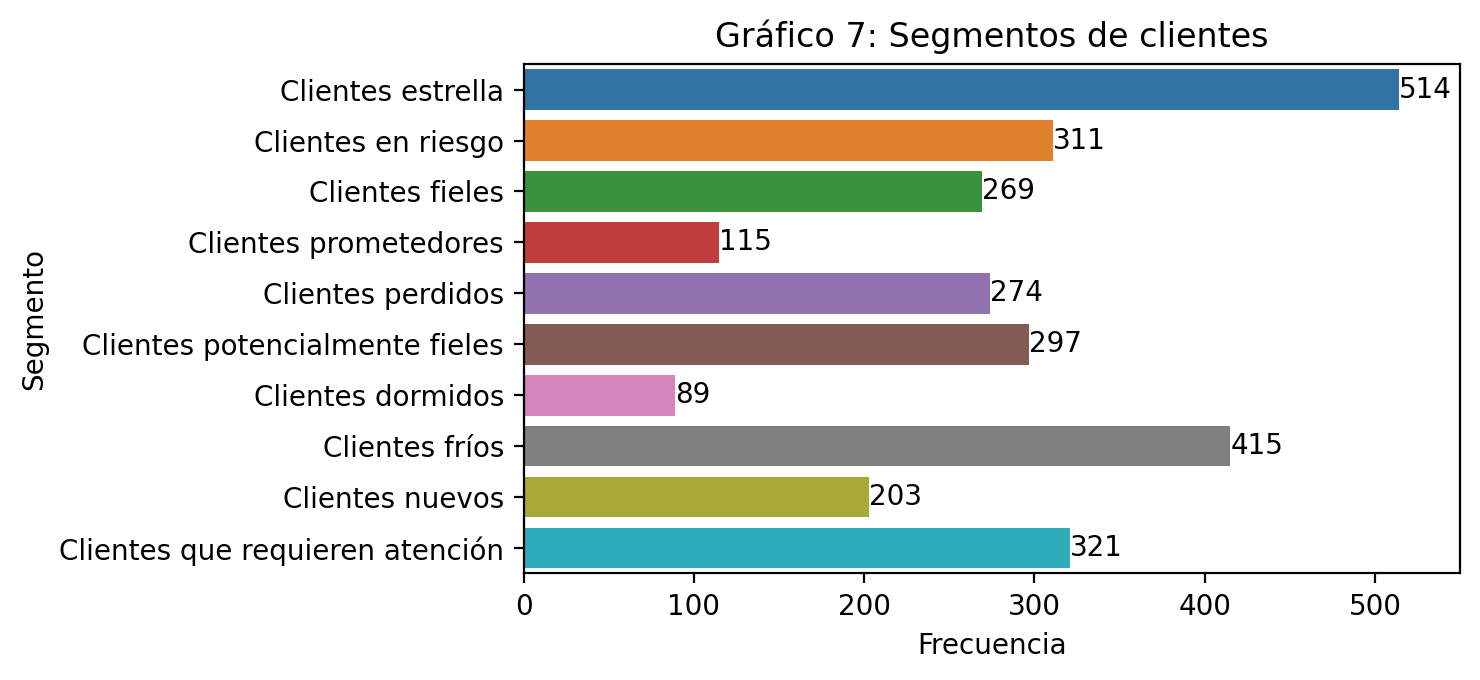

In [95]:
ax = sns.countplot(y=rfm["Segmento"])
plt.xlabel('Frecuencia')
plt.title('Gráfico 7: Segmentos de clientes')
plt.xlim(0, 550)
for container in ax.containers:
    ax.bar_label(container)

En el gráfico de barras anterior pueden observarse las cantidad exactas de cada segmento donde, el valor mínimo corresponde a los "clientes dormidos", y el valor máximo, a los "clientes estrellas".

In [96]:
rfm[["Segmento", "Recencia","Frecuencia", "Valor monetario" ]].groupby("Segmento").agg(["mean", "count"])

Recencia       Frecuencia        \
                                       mean count       mean count   
Segmento                                                             
Clientes dormidos                161.921348    89   4.382022    89   
Clientes en riesgo                94.945338   311   5.196141   311   
Clientes estrella                  8.414397   514  15.517510   514   
Clientes fieles                   24.617100   269   7.676580   269   
Clientes fríos                    91.853012   415   2.759036   415   
Clientes nuevos                   17.566502   203   2.108374   203   
Clientes perdidos                194.697080   274   2.306569   274   
Clientes potencialmente fieles    17.956229   297   4.181818   297   
Clientes prometedores             11.113043   115   2.330435   115   
Clientes que requieren atención   35.031153   321   3.573209   321   

                                Valor monetario        
                                           mean count  
Segmento                                               
Clientes dormidos                   2327.790562    89  
Clientes en riesgo                  2652.277170   311  
Clientes estrella                   9050.272704   514  
Clientes fieles                     3988.899405   269  
Clientes fríos                       744.312530   415  
Clientes nuevos                      439.352118   203  
Clientes perdidos                    405.989489   274  
Clientes potencialmente fieles       955.421616   297  
Clientes prometedores               2855.106870   115  
Clientes que requieren atención     1184.304642   321

En la tabla anterior se puede observador que los clientes que poseen el valor monetario más alto corresponden a los clientes estrella, es decir, aproximadamente el 18.30% de los clientes totales. La recencia mayor se enfoca hacia los clientes perdidos. Por otro lado, los clientes estrella también son los que poseen una mayor frecuencia en la adquisición del servicio.

# Conclusiones

<ul>
    <li>Se realizó un análisis exploratorio de datos que involucró métricas de ventas funcionales dentro del conjunto de datos empleado, estas fueron: números de facturas por país, facturas generadas por mes, clientes nuevos por mes, entre otras. En cuanto al número de facturas, se evidenció que el punto máximo fue en Noviembre del 2021, no osbtante, para el siguiente mes, esta cantidad de facturas tuvo una disminuición considerable. Una de las posibles razones de esto sea el evento "Black Friday", el cual se suscita los últimos días de Noviembre.</li>
    <li>Se realizó un análisis de cohortes mediante la tasa de retención de los clientes, para esto se seleccionaron 13 cohortes con una ventana de tiempo mensual, partiendo desde Diciembre del 2020 hasta Diciembre del 2021. Para el caso de la primera corte, "Diciembre 2020", se evidenció la tasa más alta en el penúltimo índice de la misma, siendo esta de un 50% en comparación con el valor inicial.</li>
    <li>Se realizó el análisis RFM mediante la segmentación de 10 grupos, partiendo desde los "clientes perdidos" hasta los "clientes estrellas". Los datos mostraron que la mayor cantidad de clientes pertenecen a los "clientes estrellas", mientras que la mínima está compuesta por los "clientes dormidos". </li>
</ul>